<a href="https://colab.research.google.com/github/preetamjumech/LLM/blob/main/SentimentClassification_GloVE_RNN_31_10_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import re
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras import layers, models, losses, Sequential, optimizers, metrics
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, Dense, Dropout, Embedding, GlobalMaxPooling1D, SpatialDropout1D

In [35]:
columns = ["id", "country", "Label", "Text"]

tweets_data = pd.read_csv("/content/twitter_training.csv", names = columns)
tweets_data = tweets_data.sample(frac = 0.001, random_state = 123)
print(tweets_data.shape)
tweets_data.sample(10)

(75, 4)


,id,country,Label,Text
51456,10433,RedDeadRedemption(RDR),Negative,"as if i wasn’t sad enough already . . thanks, ..."
10424,12994,Xbox(Xseries),Positive,Gimme the Xbox. It's more comfortable
4326,1945,CallOfDutyBlackopsColdWar,Positive,"Lowkey hyped for cold war, campaign is somethi..."
53533,10800,RedDeadRedemption(RDR),Positive,I treated myself to a PS4 a few months ago aft...
19719,12575,WorldOfCraft,Positive,Shoutout to wow for helping me solve something...
38254,5359,Hearthstone,Neutral,wtf hearthstone girl has graduated a new class?
12226,8501,NBA2K,Negative,@NBA2K I fuck u
5337,119,Amazon,Neutral,"Check out my debut single ""Bad Day"" its live o..."
13580,8730,NBA2K,Irrelevant,Congratulations to the champions of the second...
45717,11847,Verizon,Negative,@wbz @Verizon i have verizon cable and wbz kee...


In [36]:
tweets_data = tweets_data.drop(["id", "country"], axis = 1)
tweets_data.dropna(inplace = True, axis = 0)
tweets_data = tweets_data.drop_duplicates()
tweets_data.shape

(71, 2)

In [38]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
import string

stopwords = r"\b(?:{})\b".format("|".join(stop_words))

def clean_and_standardize_text(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses and symbols
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, stopwords, "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

In [40]:
tweets_data["Label"] = tweets_data["Label"].replace({"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant":3})

tweets_data.sample(5)

<ipython-input-40-167db2f9fa93>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tweets_data["Label"] = tweets_data["Label"].replace({"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant":3})


,Label,Text
10883,1,It’s hard to overcome how lengthy you first in...
74230,1,But Many Congratulations to @KTRTRS & @jayesh_...
48406,0,That @HomeDepot 4 days to pull in a customer p...
20345,1,I just earned the [Quintessential Family] Achi...
50310,0,Always find it funny when people get annoyed a...


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(
    tweets_data, test_size = 0.2, stratify = tweets_data["Label"], random_state = 123)
X_train, X_val = train_test_split(
    X_train, test_size = 0.1, stratify = X_train["Label"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

((50, 2), (6, 2), (15, 2))

In [42]:
BATCH_SIZE = 128
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train["Text"].values, X_train["Label"].values)).shuffle(10000).batch(BATCH_SIZE)
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val["Text"].values, X_val["Label"].values)).batch(BATCH_SIZE)
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test["Text"].values, X_test["Label"].values)).batch(BATCH_SIZE)

In [43]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250
vectorizer_layer = tf.keras.layers.TextVectorization(
    standardize = clean_and_standardize_text,
    max_tokens = VOCAB_SIZE,
    output_mode = "int",
    output_sequence_length = SEQUENCE_LENGTH

)

In [44]:
train_text = raw_train_ds.map(lambda text, label: text)
vectorizer_layer.adapt(train_text)

In [45]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorizer_layer(text), label

In [46]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [48]:
voc = vectorizer_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [49]:
# Download from https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt

import os
path_to_glove_file = "/content/glove.6B.100d.txt"

embeddings_index = {}

with open(path_to_glove_file) as f:

    for line in f:
        word, coefs = line.split(maxsplit = 1)
        coefs = np.fromstring(coefs, "f", sep = " ")

        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [50]:
num_tokens = len(voc) + 2
embedding_dim = 100

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 408 words (22 misses)


# Simple RNN

In [29]:
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, Dense, Dropout, Embedding, GlobalMaxPooling1D, SpatialDropout1D

model = Sequential()

model.add(Embedding(
    num_tokens, embedding_dim,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = True,
))

model.add(SpatialDropout1D(0.25))

model.add(SimpleRNN(units = 128, return_sequences = True))

model.add(GlobalMaxPooling1D())

model.add(Dense(32, activation = "tanh"))
model.add(Dense(4, activation = "softmax"))


In [30]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [32]:
EPOCHS = 3

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 144s 367ms/step - accuracy: 0.7366 - loss: 0.6855 - val_accuracy: 0.7232 - val_loss: 0.7248
Epoch 2/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 199s 359ms/step - accuracy: 0.7746 - loss: 0.6009 - val_accuracy: 0.7499 - val_loss: 0.6752
Epoch 3/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 143s 363ms/step - accuracy: 0.7970 - loss: 0.5417 - val_accuracy: 0.7641 - val_loss: 0.6395


In [33]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.7689 - loss: 0.6066
Loss:  0.6047512888908386
Accuracy:  0.7705317735671997


In [34]:
history_dict = history.history

history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

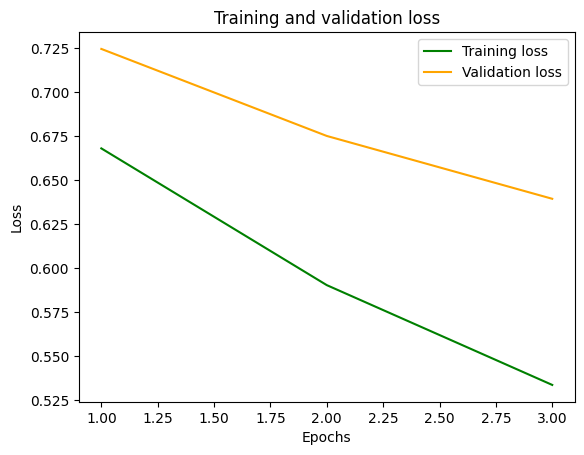

In [35]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")
plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

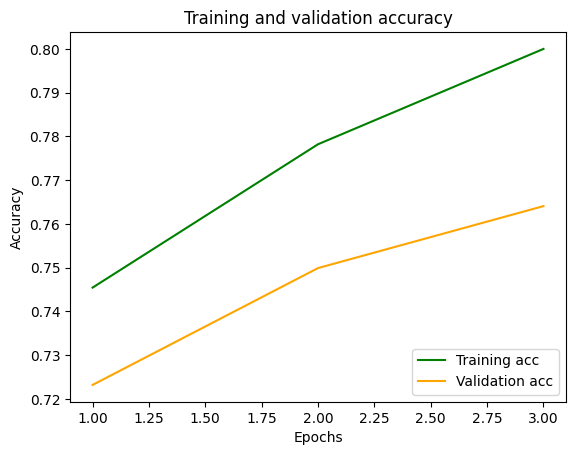

In [36]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

# LSTM

In [37]:
model = Sequential()

model.add(Embedding(
    num_tokens, embedding_dim,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = True,
))

model.add(SpatialDropout1D(0.25))

model.add(LSTM(units = 128, return_sequences = True))

model.add(GlobalMaxPooling1D())

model.add(Dense(32, activation = "tanh"))
model.add(Dense(4, activation = "softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [39]:
EPOCHS = 3

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 376s 944ms/step - accuracy: 0.4675 - loss: 1.2140 - val_accuracy: 0.5890 - val_loss: 0.9979
Epoch 2/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 366s 906ms/step - accuracy: 0.6133 - loss: 0.9493 - val_accuracy: 0.6519 - val_loss: 0.8622
Epoch 3/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 350s 891ms/step - accuracy: 0.6917 - loss: 0.7803 - val_accuracy: 0.7014 - val_loss: 0.7551


In [40]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 293ms/step - accuracy: 0.7194 - loss: 0.7160
Loss:  0.7171059250831604
Accuracy:  0.7224451899528503


In [41]:
history_dict = history.history

history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

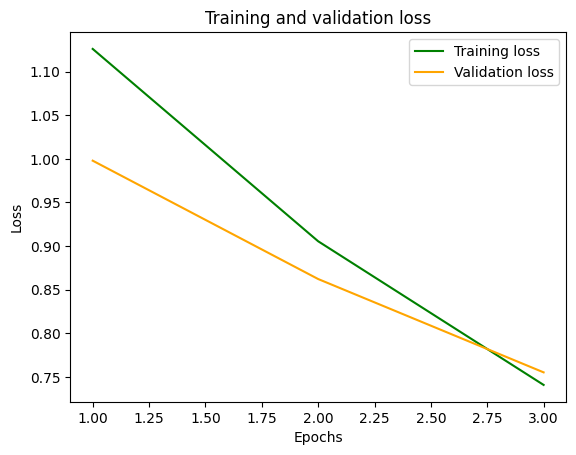

In [42]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")
plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

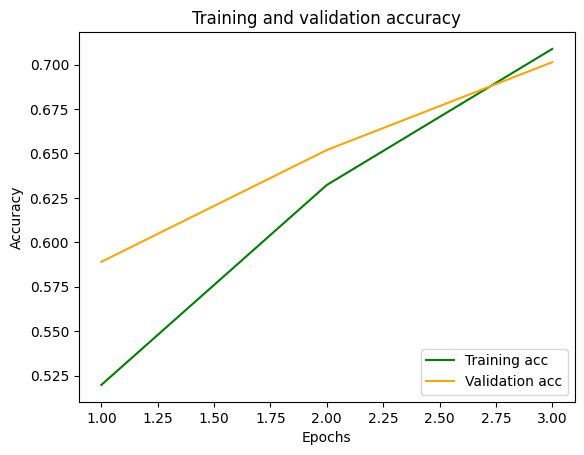

In [43]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

# Bidirectional stacked LSTM

In [44]:
model = Sequential()

model.add(Embedding(
    num_tokens, embedding_dim,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = True,
))

model.add(SpatialDropout1D(0.25))

model.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
model.add(Bidirectional(LSTM(units = 128, return_sequences = True)))

model.add(GlobalMaxPooling1D())

model.add(Dense(32, activation = "tanh"))
model.add(Dense(4, activation = "softmax"))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [46]:
EPOCHS = 3

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 1578s 4s/step - accuracy: 0.4776 - loss: 1.1987 - val_accuracy: 0.5937 - val_loss: 0.9861
Epoch 2/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 1507s 4s/step - accuracy: 0.6185 - loss: 0.9394 - val_accuracy: 0.6661 - val_loss: 0.8427
Epoch 3/3
393/393 ━━━━━━━━━━━━━━━━━━━━ 1507s 4s/step - accuracy: 0.7053 - loss: 0.7600 - val_accuracy: 0.7189 - val_loss: 0.7191


In [47]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

110/110 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.7348 - loss: 0.6814
Loss:  0.6830503940582275
Accuracy:  0.733911395072937


In [48]:
history_dict = history.history

history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

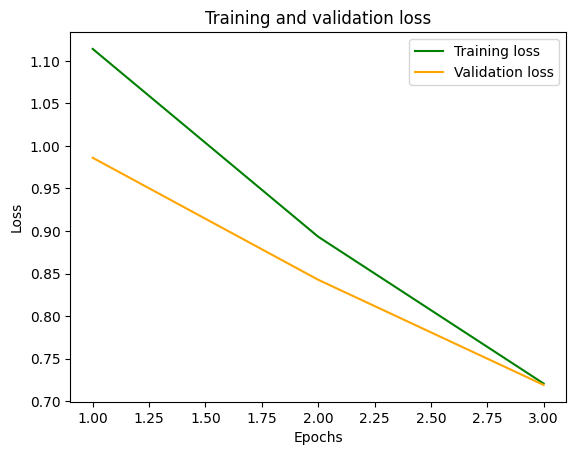

In [49]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")
plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

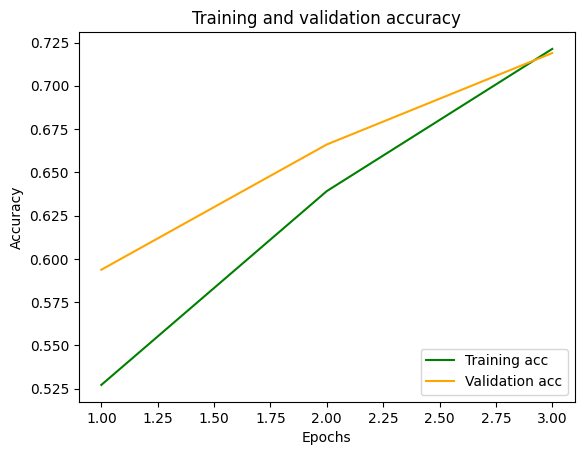

In [50]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [51]:
model.save("sentiment_predictor.keras")

In [52]:
# Loading the saved model
loaded_model = models.load_model("sentiment_predictor.keras")
loss, accuracy = loaded_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

110/110 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.7348 - loss: 0.6814
Loss:  0.6830503940582275
Accuracy:  0.733911395072937


#Hyper parameter tuning

In [4]:
pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [5]:
import keras_tuner as kt

In [27]:
def model_builder(hp):
    model = Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int("units", min_value = 128, max_value = 512 , step = 256)

    model = Sequential()
    model.add(Embedding(
      num_tokens, embedding_dim,
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = True,
    ))

    model.add(SpatialDropout1D(0.25))

    model.add(LSTM(hp_units, return_sequences = True))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(32, activation = "tanh"))
    model.add(Dense(4))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values = [1e-3, 1e-4])

    model.compile(
        optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
        loss = losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ["accuracy"]
    )

    return model

In [51]:
tuner = kt.Hyperband(
    model_builder,
    objective = "val_accuracy",
    max_epochs = 2,
    factor = 5,
    directory = "tuning",
    project_name = "sentiment_analysis",
    overwrite = True
)

In [52]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 1)

In [53]:
tuner.search(
    train_ds,
    validation_data = val_ds,
    epochs = 1, callbacks = [stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
  The hyperparameter search is complete. The optimal number of units in the first
  densely-connected layer is {best_hps.get("units")} and the optimal learning rate
  for the optimizer is {best_hps.get("learning_rate")}.
""")

Trial 2 Complete [00h 00m 19s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.5
Total elapsed time: 00h 00m 25s

  The hyperparameter search is complete. The optimal number of units in the first
  densely-connected layer is 128 and the optimal learning rate
  for the optimizer is 0.001.



In [54]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    train_ds, validation_data = val_ds,
    epochs = 1
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3000 - loss: 1.3985 - val_accuracy: 0.3333 - val_loss: 1.3676
Best epoch: 1


In [55]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(
    train_ds, validation_data = val_ds,
    epochs = best_epoch
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2400 - loss: 1.4494 - val_accuracy: 0.3333 - val_loss: 1.3538


In [56]:
eval_result = hypermodel.evaluate(test_ds)

print("[test loss, test accuracy]:", eval_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2667 - loss: 1.3578
[test loss, test accuracy]: [1.3577839136123657, 0.2666666805744171]
